# Quantum Key Distribution Protocol

## 0. Introduction
With our growing reliance on the Internet and long-distance electronic communications, a need for secure communication methods and channels has also arisen. Over the years, people have attempted to tackle this challenge via classical means, and to great success. Methods of public-key cryptography (such as RSA) and symmetric-key cryptography (such as DES and AES) have become very popular to protect communications against hackers and interceptors [3]. For the most part, these have been very effective, but the advent of quantum computing has put some of these widely-used protocols under possible danger.

Public-key cryptography, which is sometimes called asymmetric-key cryptography, is probably the most ubiquitous form of encryption used today. Its security is based on the complexity of factoring extremely large prime numbers, which was thought to be impossible in polynomial time [3]. Classically, at least, this is true, but once Peter Shor used quantum computing principles to devise the famous Shor algorithm, which factors large primes in polynomial time, the craze to build a quantum computer and harness its power really took off. Clearly, quantum computing held a different type of power that classical computing did not.

Of course, Shor's algorithm also brought some flaws in public-key cryptography to light, although one would need not only a working quantum computer, but also probably quite a powerful one to reliably hack it in reasonable time. Still, the search for newer, better encryption methods commenced. Naturally, the quantum computing hype from Shor's algorithm also spawned quantum candidates for encryption, such as quantum key distribution (QKD).

Very briefly, QKD is the umbrella term for quantum computing protocols that distribute private keys to enable secure transmission of messages, and therefore communication, between any two users. The purpose of a QKD scheme is to distribute a generated one-time pad from one party to another in a quantum fashion for use as a private key in a classical encryption/decryption regime. One-time pads have long been used to encrypt and decrypt messages, but the one downside they have is that it is very difficult to classically discern whether the one-time pad (to be used as a private key) has been intercepted by some adversary, which is a clear security concern. Luckily, that one crutch is almost completely solvable thanks to quantum mechanics and qubits, as we will show.

In this project, we investigate a certain QKD protocol called the BB84, how it protects against interceptors, and how noise affects the protocol. We also look at some methods used to reduce errors in the message and curb hackers' knowledge of the message. Finally, we demonstrate and discuss the application of QKD in an ASCII one-time pad encryption scheme.

In [3]:
# Check if qiskit is installed...
# If not installed, install with pip.
# Then import.
import imp
try:
  imp.find_module('qiskit')
  found = True
except ImportError:
  found = False
  !pip install qiskit

from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import random,randint
from random import sample
import numpy as np
import matplotlib.pyplot as plt

print("Import Success")

Import Success


## Helper Functions
Note: This section contains functions from [1]. Most of this code has been directly copied for our purposes, but a few updates have been made where necessary.  Comments describe what each function does at a high level.

In [6]:
n=100

''' Create a list of QuantumCircuits - Each 
    QuantumCircuit represents a single
    qubit in the transmitted (Alice's) message.
    Each bit is encoded in either the Z-basis
    or X-basis based on its assigned basis in
    the bases array.
'''
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Z-basis encoding
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # X-basis encoding
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

''' Applies the measurement and simulates 
    the results of measuring each qubit
'''
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # Z-basis measurement
            message[q].measure(0,0)
        if bases[q] == 1: # X-basis measurement
            message[q].h(0)
            message[q].measure(0,0)
            message[q].h(0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

''' Only keep bits that were measured in
    the same basis
'''
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            good_bits.append(bits[q])
    return good_bits

''' Compare the random selection of bits 
    received in Bob and Alice's keys
'''
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        i = np.mod(i, len(bits))
        sample.append(bits.pop(i))
    return sample

## 1. Preliminaries: How Interception Can Alter Quantum Outcomes

First, we introduce Alice, the message sender, and Bob, the message receiver, who will be used in these roles throughout this report. As a preliminary, we show that qubits can be used to communicate classical information. Suppose that Alice would like to send the bit 0 to Bob. She chooses to encode 0 in the Pauli X-basis as $|0_X\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, where $|0\rangle$ and $|1\rangle$ are eigenstates of Pauli Z operator. She can then send this qubit to Bob. If Bob measures the qubit in the X-basis, he will measure 0 (the intended bit) 100% of the time, as shown below in Figure 1.1 [1].

┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

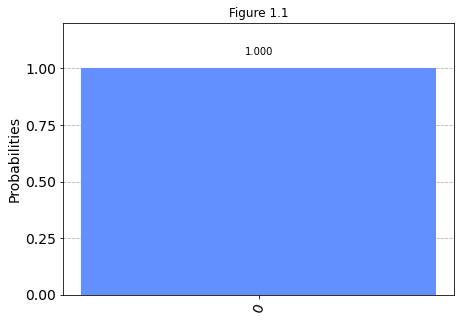

In [2]:
qc = QuantumCircuit(1,1) # This starts with qubit in state |0> by default

# Alice encodes 0 in the X-basis
qc.h(0) # Hadamard changes |0> to |+>=|0_x> 
qc.barrier() # Alice sends the qubit to Bob

# Bob measures in X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts(), title='Figure 1.1')

However, if Bob measures the bit in the Pauli Z-basis, he will only measure the bit correctly 50% of the time, as predicted by quantum mechanics and shown below in Figure 1.2.

┌───┐ ░ ┌─┐
q_0: ┤ H ├─░─┤M├
     └───┘ ░ └╥┘
c: 1/═════════╩═
              0

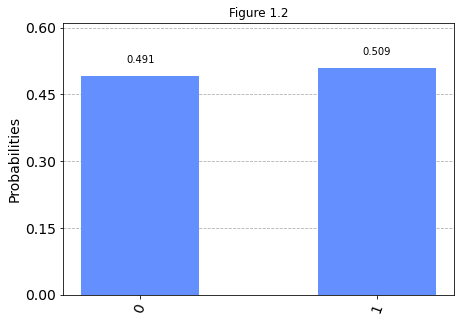

In [14]:
qc = QuantumCircuit(1,1)

# Alice encodes 0 in X-basis as |+>=|0_x>
qc.h(0)
qc.barrier() # Alice sends the qubit to Bob

# Bob measures in Z-basis
qc.measure(0,0)

display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts(), title='Figure 1.2')

By symmetry, the same applies when Alice encodes her bit in the Z-basis, and Bob measures in either the Z-basis or X-basis. Thus, if Alice encodes each of her bits using a random basis (X or Z), sends the qubits to Bob, and Bob measures the received qubits each using a random basis (X or Z), Bob will measure any given bit correctly 100% of the time when Bob uses the same basis as the one Alice used to encode that bit, and Bob will measure any given bit correctly only 50% of the time when Bob uses the other basis (the one Alice did not use to encode the bit). If Alice and Bob compare bases publicly, they can eliminate the bits that were encoded/measured in different bases, and only retain those encoded/measured in the same basis, which results in Alice and Bob having the same bits at the end.

However, an interceptor can throw a wrench in to this and introduce some error. Suppose Alice again encodes 0 in the X-basis and sends $|0_X\rangle$ to Bob. This time though, an interceptor named Eve (used as such throughout the report) comes in and measures the qubit in the Z-basis. Then, $|0_X\rangle$ is transformed into either $|0\rangle$ or $|1\rangle$ as a result of the measurement. Even if Bob measures in the X-basis now (the correct basis), he will measure the correct bit 0 only 50% of the time, and 1 50% of the time, as shown in Figure 1.3 below [1].

┌───┐┌─┐ ░ ┌───┐┌─┐
q_0: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c: 1/══════╩══════════╩═
           0          0

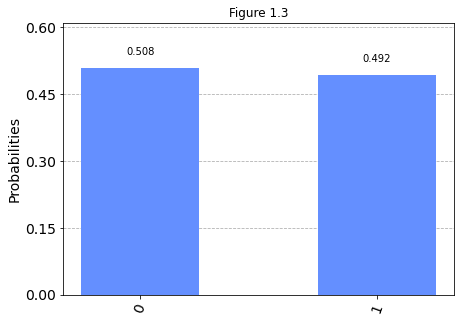

In [4]:
qc = QuantumCircuit(1,1)

# Alice encodes 0 in X-basis as |+>=|0_x>
qc.h(0)
# Alice now sends the qubit to Bob

# But Eve intercepts and measures the qubit in Z-basis!
qc.measure(0, 0)
qc.barrier()
# Eve then passes the resulting qubit (after measurement) to Bob

# Bob measures qubit in the X-basis
qc.h(0)
qc.measure(0,0)

display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts(), title='Figure 1.3')

Thus, even after the elimination of bits encoded/measured in different bases, Alice's and Bob's keys may not match, because Bob may have measured the wrong bit 1 on the intercepted bit. The act of interception has introduced error into the assumed-perfect quantum communication system!

These preliminaries show the key principle that makes QKD effective in detecting interceptors: assuming low enough noise, if Alice and Bob compare some bits in their results (after eliminating those encoded/measured in different bases), and there is error in those bits, they can be very confident that an interception has occurred, and their strings of bits can be discarded instead of being used as private keys. These observations are made more formal in the following report, looking at the effects of interceptors and noise on the BB84 QKD protocol introduced below.

## 2. BB84 Protocol

The base protocol that we will be investigating in this project is the BB84 QKD protocol [2]. Suppose Alice would like to send 100 bits to Bob to establish a private key for use in a one-time pad encryption scheme. For the message sender, Alice, and message receiver, Bob, this protocol proceeds as follows [5]:
1. Alice has classical bits that she wants to send. She first generates a string of bases (either X or Z) that is the same length as her array of bits.
2. Next, she encodes her message based on her bits and bases. For example, if her i-th bit is 0 and her i-th basis is Z, she will encode this as a qubit in state $|0\rangle$, where $|0\rangle$ and $|1\rangle$ are the usual Z eigenstate. If instead her i-th basis was X, she will encode the bit as a qubit in state $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$.
3. She then sends her generated qubit message to Bob.
4. Bob generates his own string of bases (either X or Z) in the meantime, and measures the quantum message that Alice has sent in these bases. For example, if the i-th basis is X, then Bob measures the i-th qubit in the message in basis X. This generates Bob's measured bits, or results.
5. Alice publishes her bases, and they both remove bits for which their bases differed.
6. Lastly, they publicly compare a sample of their measurements/bits to see if the sample matches. Usually, if the difference between Alice's sample and Bob's sample is below their accepted threshold level, the channel is taken to be secure enough and communication proceeds with the keys that Alice and Bob have generated and agreed upon.

Note: This code follows the code presented in [1]. This is a standard protocol upon which we will add new elements throughout the report.

In [35]:
# Throughout the report, the number of bits that Alice would like to send to establish a private key
# will be taken to be 100.
n = 100

alice_bits = randint(2, size=n)

## Step 1
alice_bases = randint(2, size=n)

## Step 2
message = encode_message(alice_bits, alice_bases)

## Step 3: Send to Bob

## Step 4
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 5
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 6
sample_size = min(15,len(bob_key))
bit_selection = sample(range(len(bob_key)), sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

## Comparing Alice's sample with Bob's
bob_sample == alice_sample

  bob_sample = [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
alice_sample = [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]


True

Upon comparing samples, Alice and Bob find that the samples are equal, and so their keys are taken to be acceptable to encrypt/trasnfer/decrypt information with. 

In the next iteration, we introduce Eve, the interceptor. As the message from Alice is being sent to Bob in Step 3, Eve decides to measure the qubits for herself in her own set of bases, and then divert/re-send the same qubits to Bob. However, since Eve has no idea which bases Alice has encoded each qubit in, she ends up measuring some qubits incorrectly, and thereby causes Bob to measure the qubit incorrectly sometimes even when Bob chooses the correct basis! This was discussed as an example in Section 1, where Eve's interception caused an error even when Bob measures the qubit in the correct basis. The fact that such an error exists can be used to test for whether someone is intercepting the message, ignoring noise for now.

Note: This code is also directly from [1]. The rest of the report expands upon and tests this protocol in various ways.

In [15]:
n = 100

alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Interception of qubits that Alice has sent to Bob!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)


bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

sample_size = min(15,len(bob_key))
bit_selection = sample(range(len(bob_key)), sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

bob_sample == alice_sample

  bob_sample = [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]
alice_sample = [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0]


False

Here, due to the interception, Alice's and Bob's samples differ in some places. If they know that noise is not present in the channel (such as in this case), they can deduce from the errors that someone must be intercepting their message, and they will not use their respective keys for communication.

## 3. Detecting the Interceptor

As noted in the previous section, the interceptor is relatively easy to detect when there is no noise deu to the error that the act of intercepting incurs. One can calculate the theoretical probability that Eve is detected due to this error. Without loss of generality, let's say that Alice sends a 0 in the Z-basis. Then Eve has a 50% chance of choosing the correct basis (Z), and a 50% chance of choosing the wrong basis (X). If Eve chooses the correct basis, the interception will necessarily go undetected, as Eve relays the same bit that she measures to Bob. If Eve chooses the wrong basis, then she sends a bit in the wrong basis to Bob. Now, Bob has a 50% chance to choose the right basis as well. If he chooses a basis different from Alice (X), the measurement result is discarded anyway, and the result would never be compared with Alice. If he chooses the correct basis (Z) after Eve has chosen the wrong one (X), then Bob may still measure the correct value of 0 50% of the time! Hence, Eve will still be undetected if Bob measures the correct value for the bit, but if Bob measures the wrong value, the error will persist in Bob's key, and Eve will be detected.

More formally, we can use the usual formula for conditional probabilities. Setting the events:

  > A = Eve chooses wrong basis <br>
  > B = Bob measures the wrong value in the correct basis,

we have that:

  >P(Eve detected over a single bit) = $P(A$ and $B)$ = $P(A)P(B|A)$ = $0.5*0.5$ = $0.25$

So if Eve intercepts every bit, the probability that any given bit compared by Alice and Bob do not match is 25%. The probability that Eve goes undetected over some k bits compared by Alice and Bob is the probability that each of the compared bits pairs correctly match, which is [1]:

  >P(Eve undetected over k compared bits) = $(0.75)^k$

So the theoretical probability that Eve is detected over those same k compared bits is:

  >P(Eve detected over k compared bits) = $1 - (0.75)^k$

This theoretical probability is plotted below versus number of compared bits.

In [590]:
# Calculating the theoretical detection probability found above over a range of bits compared
bits_compared = np.arange(1,100,2)
theoretical_detection = np.zeros(len(bits_compared))
for i in range(0,len(theoretical_detection)):
    theoretical_detection[i] = 1-(0.75**bits_compared[i])

Text(0.5, 1.0, 'Figure 3.1')

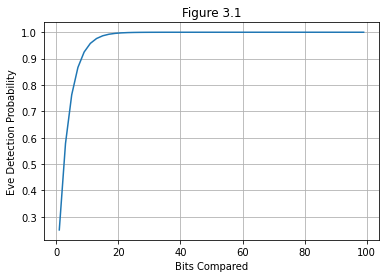

In [591]:
# Plotting the theoretical detection probability in Figure 3.1
plt.plot(bits_compared, theoretical_detection)
plt.grid(True)
plt.xlabel('Bits Compared')
plt.ylabel('Eve Detection Probability')
plt.title('Figure 3.1')

Figure 3.1 above shows that as we compare more bits, the probability that Eve (who has intercepted all of those bits) is detected increases exponentially, which makes practical sense.

We can test the detection of an interceptor empirically as well. The function below (is_Eve_detected) proceeds through the BB84 protocol with interception (as done in the previous section), and returns whether the bits compared by Alice and Bob differ anywhere. In other words, the function returns whether Eve's interception is detected (True) or not (False).

In [592]:
# This function completes the BB84 procedure, 
# and with some inputted bits_to_compare between Alice and Bob
# outputs if Eve has been detected
# by testing if the samples that Alice and Bob compare do not match.
def is_Eve_detected(bits_to_compare):
    n = 100
    
    alice_bits = randint(2, size=n)
    alice_bases = randint(2, size=n)
    message = encode_message(alice_bits, alice_bases)
    
    eve_bases = randint(2, size=n)
    intercepted_message = measure_message(message, eve_bases)

    bob_bases = randint(2, size=n)
    bob_results = measure_message(message, bob_bases)

    bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
    alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

    sample_size = min(bits_to_compare,len(bob_key))
    bit_selection = sample(range(len(bob_key)), sample_size)
    bob_sample = sample_bits(bob_key, bit_selection)
    alice_sample = sample_bits(alice_key, bit_selection)
    
    return bob_sample != alice_sample

is_Eve_detected(3)

True

Using this function, we find the empirical frequency that Eve goes undetected over various numbers of bits compared. A total of 100 trials are conducted for each specific number of bits compared.

In [16]:
# Warning: This section takes ~10 minutes to run
# Tests if Eve is detected over a range of bits_to_compare
# Each bits_to_compare is tested 100 times, and whether Eve is detected is averaged over all trials
# To get a 'Eve Detection Probability'
bits_to_compare_list = np.arange(1,20,2)
eve_detection_rate = np.ones(len(bits_to_compare_list))
attempts = 100

for j in range(0,len(bits_to_compare_list)):
    bits_to_compare = bits_to_compare_list[j]

    attempt_list = np.ones(attempts)
    for i in range(0,attempts):
        attempt_list[i] = is_Eve_detected(int(bits_to_compare))

    eve_detection_rate[j] = sum(attempt_list)/attempts
eve_detection_rate


array([0.22, 0.65, 0.77, 0.83, 0.89, 0.96, 0.96, 0.99, 0.98, 0.99])

The results are plotted below in Figure 3.2 as the probability that Eve goes undetected versus the number of bits compared by Alice and Bob. The theoretical probability plotted in Figure 3.1 is reproduced here as well to check the accuracy of the results.

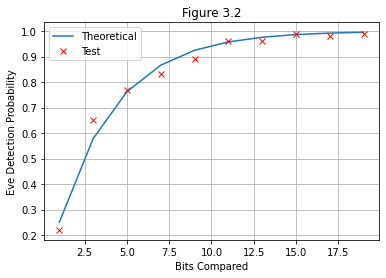

In [17]:
# Theoretical range
bits_compared = np.arange(1,20,2)
theoretical_detection = np.zeros(len(bits_compared))
for i in range(0,len(theoretical_detection)):
    theoretical_detection[i] = 1 - 0.75**bits_compared[i]

# Plotting empirical data from above
plt.plot(bits_compared, theoretical_detection, label='Theoretical')
plt.plot(bits_to_compare_list, eve_detection_rate, 'rx', label='Test')
plt.grid(True)
plt.xlabel('Bits Compared')
plt.ylabel('Eve Detection Probability')
plt.title('Figure 3.2')
plt.legend()
# plt.yscale('log')

As Figure 3.2 shows, the empirical simulation results support the theoretical conclusion: Eve is increasingly likely to get detected with more bits compared by Alice and Bob. The action of comparing many bits may come with its own security concern though, so users are often satisfied to compare just enough bits to keep the probability that an interceptor is detected above a certain threshold.

From the discussion above, we see that intercepting every single bit may not be the best course of action for the interceptor Eve. Surely she could get away with some more mischief if she intercepted and measured only some small fraction of the qubits sent by Alice. We test the possibility of this below using a couple of new functions. The function `is_Eve_detected` has been modified to include the variable `f_int`, which is the fraction of bits that Eve intercepts, with the help of the function `eve_measure_message` below.

In [7]:
# Eve Only Measuring some fraction/selection of the total bits

def eve_measure_message(message, bases, indices):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    n = len(bases)
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[indices[q]].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[indices[q]].h(0)
            message[indices[q]].measure(0,0)
            message[indices[q]].h(0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[indices[q]], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

# is_Eve_detected is modified to test whether Eve has been detected given bits_to_compare
# with an additional input what fraction of bits has been intercepted by Eve, f_int
def is_Eve_detected(bits_to_compare,f_int=1):
    n=100
    
    alice_bits = randint(2, size=n)
    alice_bases = randint(2, size=n)

    message = encode_message(alice_bits, alice_bases)

    # Eve interception
    n_eve=int(f_int*n)
    eve_bit_selection = sample(range(n), n_eve)
    eve_bases = randint(2, size=n_eve)
    intercepted_message = eve_measure_message(message, eve_bases, eve_bit_selection)

    ## Step 3
    bob_bases = randint(2, size=n)
    bob_results = measure_message(message, bob_bases)
    ## Step 4
    bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
    alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
    ## Step 5
    sample_size = bits_to_compare
    bit_selection = sample(range(len(bob_key)), sample_size)
    
    bob_sample = sample_bits(bob_key, bit_selection)
    alice_sample = sample_bits(alice_key, bit_selection)
    
    return bob_sample != alice_sample

is_Eve_detected(5,0.05)

False

We use this function to test how easy it is to detect Eve over a range of different fractions intercepted by Eve, as well as different percentage of bits compared. The results are plotted Figure 3.3 below as a heatplot, which shows the empirical percentage of times Eve was detected versus the two independent variables: percentage of bits intercepted by Eve and percentage of bits compared by Alice and Bob.

In [612]:
import pandas as pd
import seaborn as sns

# Tests if Eve is detected over a range of bits_to_compare,f_int
# Each (bits_to_compare,f_int) pair is tested  40 times, and whether Eve is detected is averaged over all trials
# To get a 'Eve Detection Probability' for the pair
bits_to_compare_list=np.arange(3,31,3)
f_int_list=np.arange(0.05,0.52,0.05)
intercept_detection_rate = np.ones((len(bits_to_compare_list),len(f_int_list)))
attempts=40

for i in range(len(bits_to_compare_list)):
    bits_to_compare=bits_to_compare_list[i]
    for j in range(len(f_int_list)):
        f_int=f_int_list[j]
        attempt_list=np.zeros(attempts)
        for k in range(attempts):
            attempt_list[k]=is_Eve_detected(bits_to_compare, f_int)
        
        intercept_detection_rate[i][j]=sum(attempt_list)/attempts

intercept_detection_rate

array([[0.   , 0.   , 0.125, 0.125, 0.2  , 0.25 , 0.225, 0.175, 0.375,
        0.325],
       [0.05 , 0.125, 0.1  , 0.2  , 0.3  , 0.45 , 0.525, 0.55 , 0.5  ,
        0.6  ],
       [0.075, 0.175, 0.4  , 0.25 , 0.4  , 0.5  , 0.45 , 0.65 , 0.65 ,
        0.675],
       [0.125, 0.3  , 0.325, 0.475, 0.675, 0.625, 0.625, 0.7  , 0.8  ,
        0.75 ],
       [0.125, 0.25 , 0.425, 0.575, 0.5  , 0.7  , 0.85 , 0.775, 0.9  ,
        0.925],
       [0.15 , 0.35 , 0.65 , 0.575, 0.6  , 0.725, 0.75 , 0.95 , 0.9  ,
        0.9  ],
       [0.2  , 0.45 , 0.525, 0.7  , 0.875, 0.725, 0.875, 0.95 , 0.9  ,
        0.95 ],
       [0.175, 0.625, 0.625, 0.75 , 0.8  , 0.85 , 0.9  , 0.9  , 1.   ,
        0.925],
       [0.25 , 0.325, 0.55 , 0.825, 0.825, 0.9  , 0.9  , 0.95 , 0.95 ,
        0.975],
       [0.475, 0.575, 0.725, 0.75 , 0.9  , 0.875, 0.95 , 0.975, 0.95 ,
        1.   ]])

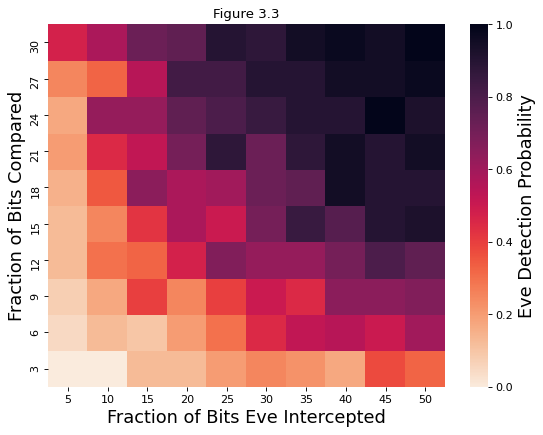

In [613]:
# Empirical data from above is plotted in a heatplot in Figure 3.3
f_int_pct_list=np.arange(5,51,5)
plt.figure(figsize=(8, 6), dpi=80)
data=pd.DataFrame(intercept_detection_rate,index=bits_to_compare_list,columns=f_int_pct_list)
ax=sns.heatmap(data, cmap = sns.cm.rocket_r, cbar_kws={'label': 'Eve Detection Probability'})
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.invert_yaxis()
ax.title.set_text('Figure 3.3')
plt.ylabel("Fraction of Bits Compared", size=16)
plt.xlabel("Fraction of Bits Eve Intercepted", size=16)
plt.show()

Looking at Figure 3.3, it can be seen that even when Alice and Bob are only comparing a small percentage of their bits publicly at the end, they are still able to detect Eve with high probability. Along any fixed percentage intercepted by Eve, we see an exponential increase in detection as bits compared increases, just as we have seen previously when Eve intercepted all bits. 

When sending a quantum key twice the length of the intended message, Alice and Bob can compare up to 50% of their bits and still have enough over for their one-time-pad. If they send even more bits, they could increase this detection rate even more to whatever minimum level of detection they desire. Furthermore, even if Eve is only measuring 10% of the bits sent, she will still get 50% of the bases wrong which means she would need to measure even more bits to truly understand the message being sent.

## 4. Introducing Noise

In the previous section, we saw that Alice and Bob were able to detect Eve by sampling their keys and checking for errors. In practice, though, there is always the possibility that an error in the compared bits is caused by noise rather than an interceptor. 

Noise is often acknowledged as one of the major roadblocks that must be overcome in highly delicate quantum systems. In this section, we introduce noise to the BB84 protocol, investigating its effects on the system and how similar it can look to the action of an interceptor. Our model of noise is essentially a bit flip in either of the two bases; applying the `apply_noise` function below imparts noise on the qubits with probability `noise_p`, where noise has the following effects on the qubits used (up to some global phase):

 > $|0\rangle \rightarrow |1\rangle$ <br>
 > $|1\rangle \rightarrow |0\rangle$ <br>
 > $|0_X\rangle = \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle) \rightarrow |1_X\rangle = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ <br>
 > $|1_X\rangle = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle) \rightarrow |0_X\rangle = \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

In [11]:
# Noise is the application of both Pauli X and Pauli Z, as described in our model description above
# For any given bit, applies noise with some probability noise_p
def apply_noise(message, noise_p):
    for q in range(len(message)):
        r = np.random.random()
        if(r<noise_p):
            message[q].x(0)
            message[q].z(0)
    
    return message

# Given a noise probability noise_p and certain bits_to_compare, performs BB84
# with noise when Alice sends qubits to Bob
# and outputs if noise has been detected by Alice and Bob (any error when they compare samples)
def is_noise_present(noise_p, bits_to_compare):
    n=100
    alice_bits = randint(2, size=n)
    ## Step 2
    alice_bases = randint(2, size=n)
    message = encode_message(alice_bits, alice_bases)
    
    ## Noise
    message = apply_noise(message, noise_p)
    
    ## Step 3
    bob_bases = randint(2, size=n)
    bob_results = measure_message(message, bob_bases)
    
    ## Step 4
    bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
    alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
    
    ## Step 5
    sample_size = min(bits_to_compare,len(bob_key))
    bit_selection = sample(range(len(bob_key)), sample_size)
    bob_sample = sample_bits(bob_key, bit_selection)
    alice_sample = sample_bits(alice_key, bit_selection)
    
    return bob_sample != alice_sample

To test that our model of noise produces the expected results, we run a several trials of BB84, applying noise as the qubits are sent from Alice to Bob using `apply_noise`. The overall proportion of Bob's key that does not match with Alice's key is calculated to see the effect of applying various noise probabilities (`noise_p`).

In [599]:
# Performs BB84 with noise over a range of different noise probabilities
# Then measures how many bits in bob_key do not match alice_key
# Giving the total proportion of errors in bob_key
# Each noise_p is tested 30 times and results are averaged over all attempts
n=100
noise_p_list = np.arange(0.,1.01,0.05)
noise_errors = np.zeros(len(noise_p_list))
attempts = 30

for j in range(len(noise_p_list)):
    noise_p = noise_p_list[j]
    
    attempt_list=np.zeros(attempts)
    for i in range(attempts):
        alice_bits = randint(2, size=n)
        ## Step 2
        alice_bases = randint(2, size=n)
        message = encode_message(alice_bits, alice_bases)

        ## Noise
        message = apply_noise(message, noise_p)

        ## Step 3
        bob_bases = randint(2, size=n)
        bob_results = measure_message(message, bob_bases)

        ## Step 4
        bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
        alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
        
        for k in range(len(bob_key)):
            attempt_list[i] += ((bob_key[k]!=alice_key[k])/len(bob_key))
    
    noise_errors[j] = sum(attempt_list)/attempts

noise_errors

array([0.        , 0.04134102, 0.10777494, 0.16575387, 0.20512173,
       0.23755169, 0.30895698, 0.37154622, 0.41258375, 0.47239561,
       0.47413746, 0.55380914, 0.60908283, 0.65365012, 0.71836123,
       0.75930196, 0.78666157, 0.84424589, 0.90126572, 0.94505095,
       1.        ])

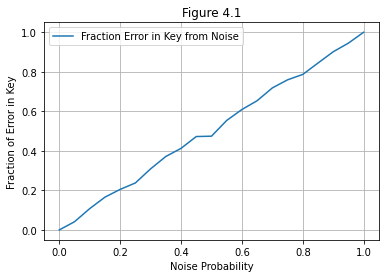

In [600]:
# Empirical data from above is plotted
plt.plot(noise_p_list, noise_errors, label='Fraction Error in Key from Noise')
plt.grid(True)
plt.xlabel('Noise Probability')
plt.ylabel('Fraction of Error in Key')
plt.title('Figure 4.1')
plt.legend()

As we see in Figure 4.1 above, the noise probability maps well to the proportion of Bob's key that differs from Alice's. Since a noise probability of $k$ causes $k$ of Bob's key to be in error, which is the desired outcome, we take this noise model to be suitable for our purposes.

Another way to see the effect of noise is to look at how often it affects the sample compared by Alice and Bob after they generate their key. Below, we test how often noise is detected by Alice and Bob over a range of different `noise_p`. The results are plotted as the frequency that noise is detected in the sample verses the noise probability (`noise_p`) used. `bits_to_compare` can be varied below to change the sample size compared Alice and Bob, but the shape of the graph displayed in Figure 4.2 remains the same.

In [606]:
# Tests whether noise is detected by Alice and Bob over a range of noise_p using is_noise_present
# Each noise_p is tested 100 times and results are averaged over all attempts
# Bits to compare is set as a constant 12
noise_p_list = np.arange(0.,1.,0.05)
noise_present = np.zeros(len(noise_p_list))
attempts = 100
bits_to_compare = 12

for j in range(len(noise_p_list)):
    noise_p = noise_p_list[j]
    
    attempt_list=np.zeros(attempts)
    for i in range(attempts):
        attempt_list[i]=is_noise_present(noise_p,bits_to_compare)
    
    noise_present[j] = sum(attempt_list)/attempts

noise_present

array([0.  , 0.49, 0.78, 0.84, 0.96, 0.95, 0.99, 0.98, 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

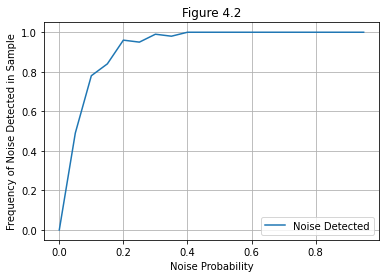

In [607]:
# Empirical simulation data from above is plotted
plt.plot(noise_p_list, noise_present,label='Noise Detected')
plt.grid(True)
plt.xlabel('Noise Probability')
plt.ylabel('Frequency of Noise Detected in Sample')
plt.title('Figure 4.2')
plt.legend()

Comparing these results with those from the Figure 3.3 across the row for 12 bits compared, we see that both figures show a fast increase from 0 towards 1 as noise probability/fraction intercepted by Eve increases, followed by a plateauing around 1 (the maximum frequency of detection, as a ratio of total trials). Ultimately, interception causes noise, which is what Alice and Bob try to detect, so this should not be of much surprise. We will now make the correspondence between interception and noise slightly more precise.

Suppose Eve intercepts a fraction `f_int` of the total bits sent by Alice. This means that Eve has intercepted `f_int` of the key as well. We reached the conclusion in the previous section that the probability that a single intercepted bit has an error due to Eve (leading to her detection) is:

> P(Eve detected over a single intercepted bit)=0.25

Now, the probability that Eve has intercepted any given given bit is simply `f_int`, so the total probability that any given bit has an error due to Eve is

> P(Error due to Eve) = $\frac{\text{f_int}}{4}$

Below, we have separately tested two protocols for several trials:
1. BB84 protocol with Eve intercepting `f_int` of the bits
2. BB84 protocol applying noise with noise probability `noise_p`$=\frac{\text{f_int}}{4}$. <br>

For each of these two cases, the fraction of Bob's key that does not match with Alice's is gathered across several different "Error Percentages", which are equal to `noise_p`$=\frac{\text{f_int}}{4}$, and the results are plotted in Figure 4.3.

In [609]:
# Comparing Interception and Noise. 
# With Error Percentage = noise_p=f_int/4
# A range of different noise_p and f_int such that noise_p=f_int/4 holds is tested
# Two separate BB84 are conducted in each trial, 
# one with interception (f_int) only and the other with noise (noise_p=f_int/4) only
# Total errors in the keys are calculated and compared
# A total of 50 attempts are conducted for ever
n=100
f_int_list=np.arange(0,0.51,0.05)
noise_p_list=f_int_list*0.25
attempts=50
int_error_pcts=np.zeros(len(f_int_list))
noise_error_pcts=np.zeros(len(noise_p_list))

for j in range(len(f_int_list)):
    f_int = f_int_list[j]
    
    attempt_list=np.zeros(attempts)
    for i in range(attempts):
        alice_bits = randint(2, size=n)
        ## Step 2
        alice_bases = randint(2, size=n)
        message = encode_message(alice_bits, alice_bases)

        ## Eve interception
        n_eve=int(f_int*n)
        eve_bit_selection = sample(range(n), n_eve)
        eve_bases = randint(2, size=n_eve)
        intercepted_message = eve_measure_message(message, eve_bases, eve_bit_selection)

        ## Step 3
        bob_bases = randint(2, size=n)
        bob_results = measure_message(message, bob_bases)

        ## Step 4
        bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
        alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
        
        for k in range(len(bob_key)):
            attempt_list[i] += ((bob_key[k]!=alice_key[k])/len(bob_key))
    
    int_error_pcts[j] = sum(attempt_list)/attempts

for j in range(len(noise_p_list)):
    noise_p = noise_p_list[j]
    
    attempt_list=np.zeros(attempts)
    for i in range(attempts):
        alice_bits = randint(2, size=n)
        ## Step 2
        alice_bases = randint(2, size=n)
        message = encode_message(alice_bits, alice_bases)

        ## Noise
        message = apply_noise(message, noise_p)

        ## Step 3
        bob_bases = randint(2, size=n)
        bob_results = measure_message(message, bob_bases)

        ## Step 4
        bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
        alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
        
        for k in range(len(bob_key)):
            attempt_list[i] += ((bob_key[k]!=alice_key[k])/len(bob_key))
    
    noise_error_pcts[j] = sum(attempt_list)/attempts

(int_error_pcts, noise_error_pcts)

(array([0.        , 0.01051179, 0.02258166, 0.04150224, 0.04389669,
        0.06997564, 0.07706209, 0.09134286, 0.10512065, 0.12042485,
        0.14176428]),
 array([0.        , 0.0122674 , 0.02459584, 0.03530905, 0.04782322,
        0.06232328, 0.06721493, 0.08773417, 0.0994345 , 0.11484363,
        0.12943252]))

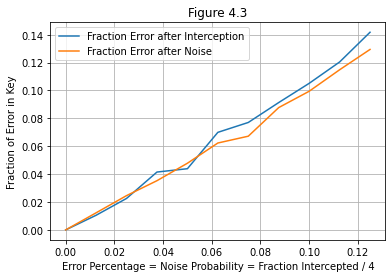

In [610]:
# Results from above are plotted
plt.plot(noise_p_list, int_error_pcts, label='Fraction Error after Interception')
plt.plot(noise_p_list, noise_error_pcts, label='Fraction Error after Noise')
plt.grid(True)
plt.xlabel('Error Percentage = Noise Probability = Fraction Intercepted / 4')
plt.ylabel('Fraction of Error in Key')
plt.title('Figure 4.3')
plt.legend()

The matching results displayed in Figure 4.3 from the two tested protocols confirm our posited connection between interception and noise: to Alice and Bob, an interceptor who intercepts some fraction $r$ of the bits looks very similar to noise that occurs with probability $\frac{r}{4}$. The only difference (a very important one, for sure) is that the interception results in the interceptor gaining knowledge of some bits as well, whereas noise is an inherent environmental nuisance.

These results also suggest that Eve may have a possible path to intercepting without being detected. If Eve were to intercept a small enough fraction of the total bits over a channel that is noisy enough (but not too noisy), she could potentially be masked by the noise, making it difficult for Alice and Bob to differentiate an interceptor from the channel's inherent noise. In the next section, we tackle the case of interception along a noisy channel.

## 5. Interception with Noise

In practice, every channel along which communication is conducted has noise. Depending on how noisy the channel is, an interceptor may be able to get away with intercepting some small fraction of bits. In this section, we develop the theory to implement interception across a noisy channel, and then apply this over ranges of different noise probabilities and fractions intercepted to see how well noise really masks and interceptor.

Suppose an interceptor attempts to listen into a noisy channel. At what point does the noise come into play: before the interception, after the interception, or both? We will use the channel model below, where the following steps occur in succession as Alice's qubits are sent to Bob:

1. Node 1: Noise is applied with `noise_p1`=$p_1$
2. Node 2: Interceptor Eve intercepts a fraction `f_int` of the bits sent
3. Node 3: Noise is applied with `noise_p2`=$p_2$

Now, suppose for now that `f_int`$=0$. Then, the bits pass through only Nodes 1 and 3 above. If the total noise probability over the entire channel is `noise_p`$=p$, then we must have that the total probability that any bit is flipped exactly once over both Nodes 1 and 3 is $p$. This probability is given below:

> P(Bit Flipped Once across Channel)$=p=p_1(1-p_2)+p_2(1-p_1)=p_1+p_2-2p_1p_2$

Thus, if we set some $p_1$ for Node 1 and some overall noise probability $p$, then $p_2$ is completely specified by:

> $p_2 = \frac{p-p_1}{1-2p_1}$

Furthermore, we can use the probability constraint that $0\leq p_2\leq1$ to further narrow the possible pairs $(p_1,p_2)$ down. This constraint suggests that:

1. When $p_1\leq\frac{1}{2}$, $p_1\leq min(p,1-p)$.
2. When $p_1\geq\frac{1}{2}$, $p_1\geq max(p,1-p)$.

By symmetry, the same applies to $p_2$. Thus, we may take any $p_1$ in the range $[0,1]-(min(p,1-p),max(p,1-p))$, and find $p_2$ from the formula derived above. The model constructed above then uses these $p_1$ and $p_2$ in Nodes 1 and 3, respectively. Applying the routine delineated by Nodes 1-3 above over a range of acceptable $p_1$ (and hence, a range of $p_2$ as well) and averaging whatever results we desire over all trials should give us a good feel for the interceptor listening into the channel at some arbitrary point in the channel.

In the function `get_avg_key_error`, we apply the method described above, taking some `f_int` and `noise_p`, and finding some suitable `noise_p1`, `noise_p2` pairs from the input `noise_p`. In each trial (for each pair `noise_p1`, `noise_p2`), the 3 nodes are applied as Alice sends her qubits to Bob. The error in Bob's key is calculated as a fraction of the total key, and averaged over all `noise_p1`, `noise_p2` pairs. The results are plotted in a heatplot in Figure 5.1, with fraction of error in keys shown versus the fraction of bits intercepted and overall noise probability.

In [611]:
# Eve + Noise
# A certain noise_p is broken into noise_p1, applied before interception, and noise_p2, applied after interception
# Error in Bob's key compared to Alice's key at the end of a BB84 protocol

def get_avg_key_error(f_int, noise_p):
    n=100
    x=min(noise_p,1-noise_p)
    attempts=20
    
    # Finds an appropriate list of 20 possible noise_p1, given noise_p
    if (noise_p>1 or f_int>1):
        return 1
    elif (noise_p==0.5):
        noise_p_list=[0.5]
    elif (noise_p==0):
        noise_p_list=[0]
    elif (noise_p==1):
        noise_p_list=[1]
    else:
        noise_p_list=np.concatenate([np.arange(0,x,x/((attempts/2)-1)),[x],np.arange(1-x,1,x/((attempts/2)-1))])
    
    num_errors_list=np.zeros(len(noise_p_list))
    percent_errors_list=np.zeros(len(noise_p_list))
    
    # For each of the possible noise_p1..
    for i in range(len(noise_p_list)):
        # Find appropraite noise_p2 given noise_p1
        p=noise_p_list[i]
        noise_p1=p
        if(p==0.5):
            noise_p2=0.5
        else:
            noise_p2=((noise_p-p)/(1-(2*p)))
        
        # Conducted BB84 with noise and interception, as per the model described in markdown above
        
        alice_bits = randint(2, size=n)
        ## Step 2
        alice_bases = randint(2, size=n)
        message = encode_message(alice_bits, alice_bases)

        ## Noise
        message = apply_noise(message, noise_p1)

        ## Interception
        n_eve=int(f_int*n)
        eve_bit_selection = sample(range(n), n_eve)
        eve_bases = randint(2, size=n_eve)
        intercepted_message = eve_measure_message(message, eve_bases, eve_bit_selection)

        ## Noise again
        message = apply_noise(message, noise_p2)

        ## Step 3
        bob_bases = randint(2, size=n)
        bob_results = measure_message(message, bob_bases)

        ## Step 4
        bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
        alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
        
        for j in range(len(bob_key)):
            num_errors_list[i] += (bob_key[j]!=alice_key[j]) # Find number of errors in key
        
        percent_errors_list[i] = num_errors_list[i]/len(bob_key) # Fraction error in key
    
    return sum(percent_errors_list)/len(noise_p_list) # Average fraction of error in key over all tested (noise_p1, noise_p2) pairs

get_avg_key_error(0.1,0.05)

0.06884015982473621

In [614]:
import pandas as pd
import seaborn as sns

# Do the above process over a range of different f_int's, noise_p's
# Calculate percent_key_errors for each pair using the above function
f_int_list=np.arange(0,0.51,0.05)
noise_p_list=np.arange(0,0.51,0.05)
percent_key_errors = np.ones((len(noise_p_list),len(f_int_list)))

for i in range(len(noise_p_list)):
    for j in range(len(f_int_list)):
        percent_key_errors[i][j]=get_avg_key_error(f_int_list[j],noise_p_list[i])

percent_key_errors

array([[0.        , 0.04347826, 0.        , 0.08      , 0.03636364,
        0.0952381 , 0.13461538, 0.12727273, 0.09615385, 0.05357143,
        0.11363636],
       [0.04960866, 0.05981087, 0.08369427, 0.07284235, 0.08523775,
        0.09419899, 0.1126809 , 0.1273515 , 0.1517974 , 0.14803698,
        0.16534221],
       [0.10831032, 0.09331752, 0.12827649, 0.12307432, 0.14119999,
        0.15432964, 0.18346011, 0.18674035, 0.199909  , 0.1887992 ,
        0.20725802],
       [0.17649556, 0.14802711, 0.17615364, 0.18058507, 0.16747829,
        0.18023104, 0.19141799, 0.20169076, 0.2025735 , 0.23014632,
        0.21939464],
       [0.21180501, 0.18236483, 0.21797138, 0.21141941, 0.24365219,
        0.22928968, 0.23940507, 0.29201369, 0.28013413, 0.26390221,
        0.26695506],
       [0.22668816, 0.27883381, 0.27598618, 0.28332998, 0.28840841,
        0.28532057, 0.27871275, 0.28320338, 0.31341381, 0.29117303,
        0.31583537],
       [0.30739085, 0.27495391, 0.30029072, 0.30797361, 0.

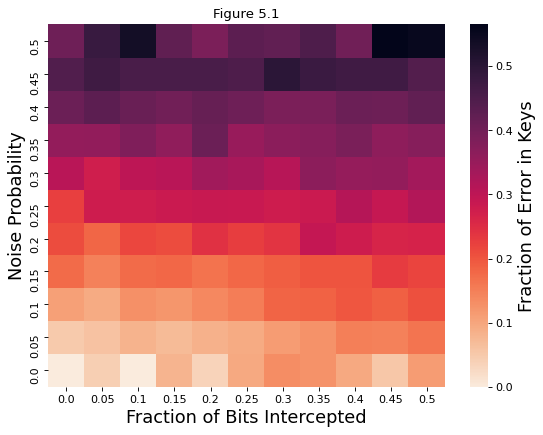

In [615]:
# Plot the data calculated in trials above using a heatplot
np_rounded=[round(p,2) for p in noise_p_list]
fi_rounded=[round(f,2) for f in f_int_list]
plt.figure(figsize=(8, 6), dpi=80)
data=pd.DataFrame(percent_key_errors,index=fi_rounded,columns=np_rounded)
ax=sns.heatmap(data, cmap = sns.cm.rocket_r, cbar_kws={'label': 'Fraction of Error in Keys'})
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.invert_yaxis()
ax.title.set_text('Figure 5.1')
plt.ylabel("Noise Probability", size=16)
plt.xlabel("Fraction of Bits Intercepted", size=16)
plt.show()

Figure 5.1 again confirms what we have anticipated. At low noise, there is generally a clear gradient as Eve intercepts a higher fraction of bits, showing that more error clearly occurs in the keys as Eve intercepts more bits. This ultimately allows Alice and Bob to better distinguish whether there is an interceptor or not, since a noticeable increase in noise from the baseline is then probably due to outside influence from an interceptor. However, at higher noises, such as a noise probability of 0.4, the fraction of error in the keys varies wildly as Eve intercepts more bits. With such a high noise probability, it is almost impossible to be confident whether an interceptor is present due to the overall noise masking noise incurred by Eve. Of course, such a noisy channel is almost never used in practice, but is instructive to investigate.

To make the notion just described a little more precise, the fraction of error in the keys is plotted versus the fraction of bits Eve intercepted on the 3 different plots below, each at different noise levels: low noise (5% noise probability), medium noise (20% noise probability), and high noise (40% noise probability). Linear regression is conducted to find and plot lines of best fit as well.

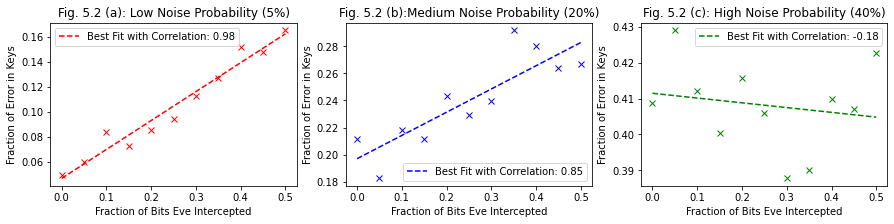

In [618]:
# Investigate 3 separate rows of the heatplot data above
# Using best fit lines and correlation
# To see how easily an interceptor is detected at different levels of noise
low_noise_errors=percent_key_errors[1,:]    # 5% noise
mid_noise_errors=percent_key_errors[4,:]    # 20% noise
high_noise_errors=percent_key_errors[8,:]    # 40% noise

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

ax[0].plot(fi_rounded,low_noise_errors,'rx')
m0, b0 = np.polyfit(fi_rounded,low_noise_errors, 1)
best_fit0=[m0*fi+b0 for fi in fi_rounded]
r0=np.corrcoef(fi_rounded,low_noise_errors)[0,1]
ax[0].title.set_text('Fig. 5.2a: Low Noise Probability (5%)')
ax[0].plot(fi_rounded, best_fit0, 'r--',label="Best Fit with Correlation: " + str(round(r0,2)))
ax[0].legend()

ax[1].plot(fi_rounded,mid_noise_errors,'bx')
m1, b1 = np.polyfit(fi_rounded,mid_noise_errors, 1)
best_fit1=[m1*fi+b1 for fi in fi_rounded]
r1=np.corrcoef(fi_rounded,mid_noise_errors)[0,1]
ax[1].title.set_text('Fig. 5.2b:Medium Noise Probability (20%)')
ax[1].plot(fi_rounded, best_fit1, 'b--', label="Best Fit with Correlation: " + str(round(r1,2)))
ax[1].legend()

ax[2].plot(fi_rounded,high_noise_errors,'gx')
m2, b2 = np.polyfit(fi_rounded,high_noise_errors, 1)
best_fit2=[m2*fi+b2 for fi in fi_rounded]
r2=np.corrcoef(fi_rounded,high_noise_errors)[0,1]
ax[2].title.set_text('Fig. 5.2c: High Noise Probability (40%)')
ax[2].plot(fi_rounded, best_fit2, 'g--', label="Best Fit with Correlation: " + str(round(r2,2)))
ax[2].legend()

plt.setp(ax[:], xlabel='Fraction of Bits Eve Intercepted')
plt.setp(ax[:], ylabel='Fraction of Error in Keys')

plt.show()

Figure 5.2 clearly indicates the difference in detectability of Eve across various noise probabilities. At low and even medium noise probabilities (Figure 5.2a,b), the correlation coefficient indicates a great correlation between fraction of bits intercepted by Eve and the fraction of error in the keys. Thus, an interceptor will tend to introduce more noise in almost all cases, and a greater amount of noise can be linked to the presence of an interceptor with high confidence. On the other hand, at high noise probabilities (Figure 5.2c), the correlation coefficient indicates almost no correlation between fraction of bits intercepted by Eve and the fraction of error in the keys. In several cases, there was even less error when Eve intercepted bits than there was at the baseline without interception. Thus, an interceptor cannot really be detected with any confidence at this level of noise. As stated earlier, if such a channel is treated as acceptable, and Eve intercepts bits early in the channel prior to noise error accumulation, Eve could certainly gather a lot of information about Alice's key.

These data only add to the long list of reasons why reducing noise, especially in quantum systems, is so important and highly researched. Fortunately, such noisy channels are generally not acceptable, and even if they were, there are measures to protect against errors and interceptors, as will be discussed in the next section.

## 6. Protecting Against Interceptors and Errors

As detailed in the previous sections, although we have a relatively nice way to detect interceptors and noise via error detection, we have not discussed any methods or algorithms used to protect against these menaces yet. There are many of such algorithms about, but in this report we will investigate the effectiveness of one specific error elimination protocol and another privacy amplification protocol from [5], both of which use the commonly employed classical method of comparing bit parities. Both protocols are carried out after the BB84 protocol by Alice and Bob on their respective keys.

The error elimination protocol is as follows [5]:
1. Alice and Bob communicate which bits to pair together and compute each pair's parity.
2. Alice and Bob compare parities.
3. If Alice's and Bob's parity do not match for a certain bit pair, both of those bits are discarded by both parties.
4. Repeat this process until the expected number of errors is less than 1.

The privacy amplification protocol is as follows [5]:
1. Alice and Bob communicate which bits to pair together and compute each pair's parity.
2. Use these parities as the new bits in the key.
3. Repeat this process until the expected number of bits known by Eve is less than 1.

Typically, privacy amplification is performed after the error elimination protocol [5]. To use these protocols, we must first calculate the initial expected number of errors and expected number of bits known by Eve after error elimination. The initial expected number of errors can be calculated as follows. Consider our channel model from Section 5, with noise and interception. The nodes in the model are reproduced below:

1. Node 1: Noise is applied with `noise_p1`=$p_1$
2. Node 2: Interceptor Eve intercepts a fraction `f_int`=$f$ of the bits sent
3. Node 3: Noise is applied with `noise_p2`=$p_2$

For any given bit, Eve can either not intercept the bit (probability $1-f$), measure the bit in the right basis (probability $\frac{f}{2}$), or measure the bit in the wrong basis $\frac{f}{2}$. Either of the former two outcomes results in Eve not changing the bit (probability $1-\frac{f}{2}$), but the latter outcomes necessarily changes the bit (probability $\frac{f}{2}$). 

If Eve does not change the bit to a new basis, then noise proceeds as normal, so the probability that the given bit has error (flipped exactly once) is $p_1(1-p_2)+p_2(1-p_1)=p$. This error is measured by Bob if Bob chooses the right basis. The total probability that these outcomes happen to any given bit is $p(1-\frac{f}{2})$.

If Eve _does_ change the bit to a new basis, then it does not matter if or when our particular noise is applied; Bob will necessarily measure an incorrect bit 50% of the time in the correct basis. The total probability that these events occur is $\frac{f}{4}$.

Now, if Bob's key has length $L$, then his key contains an expected number of errors $E_0$ of

> $E_0 = L(p-\frac{pf}{2}+\frac{f}{4})$

In our version of error elimination, after each iteration of the method, we multiply the expected errors $E_0$ by a multiplicative factor of $p+f-pf$, which is guaranteed to be between 0 and 1 and produces the correct result in the case when either $p=0$ or $f=0$. This gives us $E_1=(p+f-pf)E_0$. Note that this is simply a postulation, and results of the protocol are satisfactory enough to accept it. The protocol ends when we iterate enough times such that $E_n<1$.

For privacy amplification, we need to calculate the total expected bits known to Eve after the error elimination. These are the bits known to Eve that did not induce errors. When Eve intercepts and does not change the bit, she measures the correct outcome 100% of the time and matches that of Bob's and Alice's, as long as both Node 1 and Node 2 do not interfere. These composite outcomes occur with probability $\frac{f}{2}(1-p_1)(1-p_2)$, but to simplify the code and calculations, we take an upper bound of $\frac{f}{2}(1-p)$, which occurs when either $p_1=0$ or $p_2=0$. Taking upper bounds can only make the amplification process stronger as we increase the amount of expected successfully intercepted bits, so this is not of concern to us. 

Another way for Eve to know a bit that matches both Bob's and Alice's (one that skirts error elimination) is for Eve to use the wrong basis, end up measuring the correct value, and for Bob to luckily end up measuring the correct value as well in the wrong basis. Overall, the probability that Eve uses the wrong basis and Bob still measuring the correct value in the right basis (same basis as Alice) is $\frac{f}{4}$. The probability that Eve measures the correct value in this case is 50%, so the total probability is $\frac{f}{8}$.

Combining these two, if Bob's key is length $L$, the overall number of those bits known to Eve after error elimination $K_0$ is given by:

> $K_0 \approx L[\frac{f}{2}(1-p)+\frac{f}{8}]$

After each iteration of the privacy amplification algorithm, we multiply $K_0$ by the factor of $f$, which again is the correct multiplicative factor in the case of no noise, but also provides an effective upper bound in the case where noise is present. This multiplication give us $K_1=fK_0$, which is used as the expected number of bits known in the next iteration. The protocol ends when we iterate enough times such that $K_n<1$.

The functions below implement the two protocols described above, using the theory developed to perform a sufficient number of iterations.

In [10]:
# Generates pairs of indices given bits. Parities will be computed between bits at these indeices.
def generate_index_pairs(bits):
    n=len(bits)
    index_pairs=[]
    rsamp=sample(range(n),n)
    for i in range(int(n/2)):
        index_pairs.append([rsamp[2*i],rsamp[(2*i)+1]])
    if(n%2): 
        index_pairs.append([rsamp[n-1]])
    
    return index_pairs

# Pairs bits based on index pairs generated by generate_index_pairs
def pair_bits(bits, index_pairs):
    bit_pairs=[]
    for arr in index_pairs:
        if(len(arr)!=2):
            bit_pairs.append([1])
        else:
            bit_pairs.append([bits[arr[0]],bits[arr[1]]])
    
    return bit_pairs

# Parities computed between bit pairs generated by pair_bits
def compute_parities(bit_pairs):
    parities=[]
    for arr in bit_pairs:
        if(len(arr)!=2):
            parities.append(1)
        else:
            parities.append(arr[0]^arr[1])

    return parities

# Removes pairs of bits from a_bits and b_bits if the parities of those two bits do not match between Alice and Bob
def remove_pairs_by_parity(index_pairs,a_bits,a_parities,b_bits,b_parities):
    indexes_to_remove=[]
    for i in range(len(a_parities)):
        if(a_parities[i]!=b_parities[i]):
            indexes_to_remove+=index_pairs[i]
    
    
    return (np.delete(a_bits,indexes_to_remove),np.delete(b_bits,indexes_to_remove))

# Error Elimination Protocol described in the theory presented in markdown above
def eliminate_errors(a_key, b_key, noise_p=0, f_int=0):
    n=100
    
    a_bits=a_key
    b_bits=b_key
    error_p = (noise_p-(noise_p*f_int/2)+(f_int/4))
    improvement_per_iteration = noise_p + f_int - (noise_p*f_int)
    expected_errors=len(a_bits)*error_p
    
    if((error_p>1) or (error_p<0)):
        return (a_bits,b_bits)
    elif((error_p==1)):
        return ([],[])
    
    while(expected_errors>=1):
        index_pairs=generate_index_pairs(a_bits)
        a_pairs=pair_bits(a_bits,index_pairs)
        b_pairs=pair_bits(b_bits,index_pairs)
        a_parities=compute_parities(a_pairs)
        b_parities=compute_parities(b_pairs)
        bits=remove_pairs_by_parity(index_pairs,a_bits,a_parities,b_bits,b_parities)
        a_bits=bits[0]
        b_bits=bits[1]
        expected_errors *= improvement_per_iteration
    
    return (a_bits,b_bits)

# Privacy Amplification Protocol described in the theory presented in markdown above
def amplify_privacy(a_key, b_key, noise_p=0, f_int=0, after_error_elim=1):
    n=100
    
    if(after_error_elim):
        a_bits=a_key
        b_bits=b_key
    else:
        (a_bits,b_bits) = eliminate_errors(a_key, b_key, noise_p, f_int)
    
    known_p = ((f_int*(1-noise_p)/2) + (f_int/8))
    improvement_per_iteration = f_int
    expected_known = len(a_bits)*known_p
    
    if((known_p>1) or (known_p<0)):
        return (a_bits,b_bits)
    elif((known_p==1)):
        return ([],[])
    
    while(expected_known>=1):
        index_pairs=generate_index_pairs(a_bits)
        a_pairs=pair_bits(a_bits,index_pairs)
        b_pairs=pair_bits(b_bits,index_pairs)
        a_bits=compute_parities(a_pairs)
        b_bits=compute_parities(b_pairs)
        expected_known *= improvement_per_iteration
    
    return (a_bits,b_bits)

In [625]:
n=100
f_int=0.05
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Interception: A fraction is intercepted.
n_eve=int(f_int*n)
eve_bit_selection = sample(range(n), n_eve)
eve_bases = randint(2, size=n_eve)
intercepted_message = eve_measure_message(message, eve_bases, eve_bit_selection)

bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

# Conduct error elimination and privacy amplification
(alice_error_corrected, bob_error_corrected)=eliminate_errors(alice_key,bob_key,noise_p=0,f_int=f_int)
(alice_final, bob_final)=amplify_privacy(alice_error_corrected,bob_error_corrected,noise_p=0,f_int=f_int,after_error_elim=1)

alice_final==bob_final

True

The error elimination and privacy amplification protocols are useful in a wide variety of scenarios, a few of which have been tested below. First, we look at the case in which there is no noise, but Eve intercepts some fraction of the qubits sent by Alice to Bob. The BB84 protocol is carried out, followed by Alice and Bob going through the error elimination and privacy amplification protocols as well. Several trials were conducted over a range of different fractions intercepted. The numbers of bits and errors in the keys before and after the two correction protocols are plotted against the fraction of bits intercepted and plotted in Figure 6.1 below.

In [626]:
# Error Elimination and Privacy Amplification after Eve's interception
# Tested over a range of different f_int
# Total numbers of bits and errors right before the two protocols and right after both protocols are computed
# in each trial
# A total of 40 trials per f_int
f_int_list = np.arange(0.,1.,0.05)
num_bits_before = np.zeros(len(f_int_list))
num_bits_after = np.zeros(len(f_int_list))
num_errors_before = np.zeros(len(f_int_list))
num_errors_after = np.zeros(len(f_int_list))
attempts = 40

for j in range(0,len(f_int_list)):
    f_int = f_int_list[j]
    
    num_bits_before_list = np.zeros(attempts)
    num_errors_before_list = np.zeros(attempts)
    num_bits_after_list = np.zeros(attempts)
    num_errors_after_list = np.zeros(attempts)
    for i in range(0,attempts):
        n=100
        alice_bits = randint(2, size=n)
        alice_bases = randint(2, size=n)
        message = encode_message(alice_bits, alice_bases)
        ## Interception: A fraction is intercepted. If f_int is not specified, default is 1
        n_eve=int(f_int*n)
        eve_bit_selection = sample(range(n), n_eve)
        eve_bases = randint(2, size=n_eve)
        intercepted_message = eve_measure_message(message, eve_bases, eve_bit_selection)
        ## Step 3
        bob_bases = randint(2, size=n)
        bob_results = measure_message(message, bob_bases)
        ## Step 4
        bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
        alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
        (alice_error_corrected, bob_error_corrected)=eliminate_errors(alice_key,bob_key,noise_p=0,f_int=f_int)
        (alice_final, bob_final)=amplify_privacy(alice_error_corrected,bob_error_corrected,noise_p=0,f_int=f_int,after_error_elim=1)
        
        num_bits_before_list[i] = len(alice_key)
        num_bits_after_list[i] = len(alice_final)
        for k in range(len(alice_key)):
            if alice_key[k]!=bob_key[k]:
                num_errors_before_list[i]+=1
        for k in range(len(alice_final)):
            if alice_final[k]!=bob_final[k]:
                num_errors_after_list[i]+=1
                
    num_bits_before[j] = sum(num_bits_before_list)/attempts
    num_errors_before[j] = sum(num_errors_before_list)/attempts
    num_bits_after[j] = sum(num_bits_after_list)/attempts
    num_errors_after[j] = sum(num_errors_after_list)/attempts

(num_bits_before, num_bits_after, num_errors_before, num_errors_after)

(array([49.8  , 50.275, 51.925, 50.275, 48.95 , 49.65 , 49.275, 51.175,
        51.025, 51.35 , 48.25 , 49.275, 50.325, 49.65 , 50.875, 51.3  ,
        50.175, 49.575, 51.025, 50.375]),
 array([49.8  , 25.4  , 25.025, 22.95 , 11.3  , 11.5  , 10.075,  5.85 ,
         5.225,  3.225,  2.675,  1.675,  1.   ,  1.   ,  1.   ,  1.   ,
         1.   ,  1.   ,  1.   ,  1.   ]),
 array([ 0.   ,  0.725,  1.225,  2.15 ,  2.675,  2.7  ,  4.   ,  4.7  ,
         6.075,  5.35 ,  5.675,  6.825,  7.625,  7.975,  9.7  ,  9.3  ,
        10.1  , 10.5  , 11.375, 11.2  ]),
 array([0.   , 0.7  , 0.05 , 0.1  , 0.075, 0.175, 0.05 , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

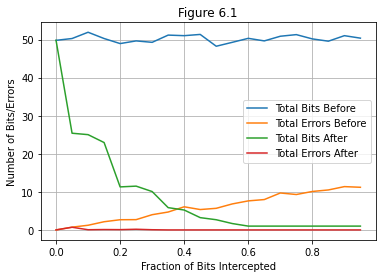

In [627]:
# Data from above is plotted in Figure 6.1
plt.plot(f_int_list, num_bits_before, label='Total Bits Before')
plt.plot(f_int_list, num_errors_before, label='Total Errors Before')
plt.plot(f_int_list, num_bits_after, label='Total Bits After')
plt.plot(f_int_list, num_errors_after, label='Total Errors After')
plt.grid(True)
plt.xlabel('Fraction of Bits Intercepted')
plt.ylabel('Number of Bits/Errors')
plt.title('Figure 6.1')
plt.legend()

Figure 6.1 shows the previously seen results for total bits and errors in the keys before error elimination and privacy amplification: without these two protocols, the total bits in the keys are approximately half that of the total bits received by Bob, and as the fraction of qubits intercepted increases, we see that the number of errors increases out of these bits increases as well. However, after the two protocols are carried out, we see that error is successfully eliminated (very close to 0) regardless of the fraction intercepted. As a side effect of the two protocols though (mainly privacy amplification), the number of bits left to use is significantly decreased, and if Eve is intercepting a large fraction of the bits, almost no bits remain to be used. This is of course necessary to ensure Eve knows <1 bit.

Next, we look at the case of noise, but no interceptor. If Alice and Bob are sure there is no interceptor, they only carry out the error elimination protocol on their keys from BB84. This protocol is tested over various noise probabilities, tracking numbers of bits and errors immediately before and after the protocol is carried out. The resulting data is plotted in Figure 6.2 below versus noise probability.

In [633]:
# Error Elimination after Noise
# Tested over a range of different noise_p
# Total numbers of bits and errors right before the two protocols and right after both protocols are computed
# in each trial
# A total of 40 trials per noise_p
noise_p_list = np.arange(0.,1.,0.05)
num_bits_before = np.zeros(len(noise_p_list))
num_bits_after = np.zeros(len(noise_p_list))
num_errors_before = np.zeros(len(noise_p_list))
num_errors_after = np.zeros(len(noise_p_list))
attempts = 40

for j in range(0,len(noise_p_list)):
    noise_p = noise_p_list[j]
    
    num_bits_before_list = np.zeros(attempts)
    num_errors_before_list = np.zeros(attempts)
    num_bits_after_list = np.zeros(attempts)
    num_errors_after_list = np.zeros(attempts)
    for i in range(0,attempts):
        n=100

        alice_bits = randint(2, size=n)
        ## Step 2
        alice_bases = randint(2, size=n)
        message = encode_message(alice_bits, alice_bases)

        ## Noise
        message = apply_noise(message, noise_p)

        ## Step 3
        bob_bases = randint(2, size=n)
        bob_results = measure_message(message, bob_bases)

        ## Step 4
        bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
        alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
        
        ## Error Elimination after Noise
        (alice_errors_eliminated,bob_errors_eliminated)=eliminate_errors(alice_key, bob_key, noise_p=noise_p, f_int=0)
        
        num_bits_before_list[i] = len(alice_key)
        num_bits_after_list[i] = len(alice_errors_eliminated)
        for k in range(len(alice_key)):
            if alice_key[k]!=bob_key[k]:
                num_errors_before_list[i]+=1
        for k in range(len(alice_errors_eliminated)):
            if alice_errors_eliminated[k]!=bob_errors_eliminated[k]:
                num_errors_after_list[i]+=1
                
    num_bits_before[j] = sum(num_bits_before_list)/attempts
    num_errors_before[j] = sum(num_errors_before_list)/attempts
    num_bits_after[j] = sum(num_bits_after_list)/attempts
    num_errors_after[j] = sum(num_errors_after_list)/attempts

(num_bits_before, num_bits_after, num_errors_before, num_errors_after)

(array([50.125, 49.05 , 50.175, 48.55 , 50.25 , 50.2  , 49.55 , 49.3  ,
        49.675, 49.625, 48.925, 48.775, 49.725, 49.85 , 49.9  , 49.35 ,
        49.975, 50.725, 50.925, 50.125]),
 array([50.125, 44.05 , 40.325, 35.1  , 30.45 , 24.75 , 20.4  , 16.1  ,
        10.725,  7.375,  4.975,  6.375,  9.825, 14.2  , 19.5  , 24.5  ,
        28.725, 36.875, 41.475, 45.475]),
 array([ 0.   ,  2.625,  5.45 ,  7.1  , 10.15 , 13.275, 14.625, 16.9  ,
        19.7  , 22.35 , 23.85 , 26.025, 29.175, 32.   , 34.7  , 36.925,
        39.35 , 43.8  , 46.2  , 47.8  ]),
 array([ 0.   ,  0.125,  0.525,  0.375,  0.25 ,  0.55 ,  0.05 ,  0.3  ,
         0.225,  1.225,  1.875,  4.825,  9.225, 14.175, 19.5  , 24.5  ,
        28.725, 36.875, 41.475, 45.475]))

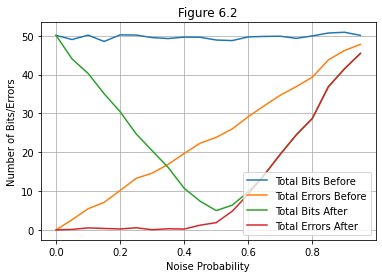

In [634]:
# Data from above is plotted
plt.plot(noise_p_list, num_bits_before, label='Total Bits Before')
plt.plot(noise_p_list, num_errors_before, label='Total Errors Before')
plt.plot(noise_p_list, num_bits_after, label='Total Bits After')
plt.plot(noise_p_list, num_errors_after, label='Total Errors After')
plt.grid(True)
plt.xlabel('Noise Probability')
plt.ylabel('Number of Bits/Errors')
plt.title('Figure 6.2')
plt.legend(loc='lower right')

The results in Figure 6.2 may look surprising. When noise probability is in the range 0-0.4, results follow the same trend as those in Figure 6.1; the error elimination protocol tends to reduce the number of bits to eliminate errors, with more bits being eliminated as the noise probability, and hence number of errors, increases. However, at a noise probability of 0.5, the graph seems to take an unexpected U-turn, and eventually, all retained bits from error elimination are actually errors!

When we look at how the protocol works though, this is actually the expected outcome with such a high portion of errors. This is ultimately a result of how parity works. Consider the following simple scenario:

> Alice key: 001001 <br>
> Bob key: 010110

In this scenario, only the first bit (bit 1) matches between Alice and Bob, so there is an error of 5/6 (which can be incurred by noise with a noise probability of 83.3% in a reasonable portion of cases). If we simply pair bits 1-2, 3-4, 5-6 and calculate parities, we have:

> Alice parities: 011 <br>
> Bob parities: 111

As a result, Alice and Bob eliminate bits 1 and 2, even though bit 1 is the only correct bit! The result is then:

> Alice result: 1001 <br>
> Bob result: 0110

in which we are left with 100% error (all remaining bits are errors). Now, no matter which way we calculate the parity, none of the remaining bits are eliminated, since 0^0=1^1 and 0^1=1^0, where ^ is XOR (parity calculation). Thus, if most of Bob's bits do not match Alice's, the error elimination protocol will ultimately give Bob a result with 100% error, perfectly opposite to Alice's result. One way to work around this is to compare a small number of bits (maybe 2 or 3) at the end of the error elimination protocol. If there are errors, Bob can flip all of his bits and try comparing a sample again to verify that his bits match Alice's. This simulation is another great lesson on why reducing noise is so important. Such noisy channels are essentially useless in reality though, so this would not be much of an issue in practice.

Lastly, we simulate the scenario where Alice and Bob out both error elimination and privacy amplification after BB84 in the case that there is both noise (with noise probability `noise_p`) and an interceptor intercepting a fraction of the total qubits sent (fraction `f_int`). This interception with noise is implemented in a similar way as was done in Section 5. The fraction of resultant bits that are errors after the two protocols is calculated over ranges of different fractions intercepted and noise probabilities. The results are displayed in Figure 6.3 on a heatplot.

In [8]:
# Error Elimination and Privacy Amplification for Eve + Noise
# get_avg_key_error from section 5 is modified to perform error elimination and privacy amplification at the end
def get_avg_key_error_with_corrections(f_int, noise_p):
    n=100
    x=min(noise_p,1-noise_p)
    attempts=20
    
    if (noise_p>1 or f_int>1):
        return 1
    elif (noise_p==0.5):
        noise_p_list=[0.5]
    elif (noise_p==0):
        noise_p_list=[0]
    elif (noise_p==1):
        noise_p_list=[1]
    else:
        noise_p_list=np.concatenate([np.arange(0,x,x/((attempts/2)-1)),[x],np.arange(1-x,1,x/((attempts/2)-1))])
    
    num_errors_list=np.zeros(len(noise_p_list))
    percent_errors_list=np.zeros(len(noise_p_list))
    
    for i in range(len(noise_p_list)):
        p=noise_p_list[i]
        noise_p1=p
        if(p==0.5):
            noise_p2=0.5
        else:
            noise_p2=((noise_p-p)/(1-(2*p)))
        
        alice_bits = randint(2, size=n)
        
        alice_bases = randint(2, size=n)
        message = encode_message(alice_bits, alice_bases)

        ## Noise
        message = apply_noise(message, noise_p1)

        ## Interception
        n_eve=int(f_int*n)
        eve_bit_selection = sample(range(n), n_eve)
        eve_bases = randint(2, size=n_eve)
        intercepted_message = eve_measure_message(message, eve_bases, eve_bit_selection)

        ## Noise again
        message = apply_noise(message, noise_p2)

        
        bob_bases = randint(2, size=n)
        bob_results = measure_message(message, bob_bases)

        
        bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
        alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
        
        # Error Elimination
        (alice_errors_eliminated,bob_errors_eliminated)=eliminate_errors(alice_key, bob_key, noise_p=noise_p, f_int=f_int)
        
        # Privacy Amplification
        (alice_final_bits,bob_final_bits)=amplify_privacy(alice_errors_eliminated,bob_errors_eliminated, noise_p=noise_p, f_int=f_int, after_error_elim=1)
        
        
        for j in range(len(bob_final_bits)):
            num_errors_list[i] += (bob_final_bits[j]!=alice_final_bits[j])
        
        percent_errors_list[i] = num_errors_list[i]/len(bob_key)
    
    return sum(percent_errors_list)/len(noise_p_list)

In [12]:
import pandas as pd
import seaborn as sns

# The above function is tested over a range of different f_int and noise_p to find 
# percent errors after the two correction protocols for each (f_int, noise_p) pair
f_int_list=np.arange(0,0.51,0.05)
noise_p_list=np.arange(0,0.51,0.05)
percent_key_errors_w_correction = np.ones((len(noise_p_list),len(f_int_list)))

for i in range(len(noise_p_list)):
    for j in range(len(f_int_list)):
        percent_key_errors_w_correction[i][j]=get_avg_key_error_with_corrections(f_int_list[j],noise_p_list[i])

percent_key_errors_w_correction

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00204082, 0.00462433, 0.0039673 , 0.0038624 , 0.        ,
        0.00185185, 0.        , 0.00196078, 0.        , 0.        ,
        0.        ],
       [0.01644849, 0.00978721, 0.00210526, 0.00223964, 0.        ,
        0.00847529, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.01299371, 0.00435231, 0.00592293, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00210611, 0.0018797 , 0.00685771, 0.        , 0.00269906,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.02101672, 0.00734674, 0.        , 0.00828142, 0.        ,
        0.        , 0.00116959, 0.00107411, 0.        , 0.        ,
        0.        ],
       [0.00678404, 0.00270748, 0.00194932, 0.        , 0.

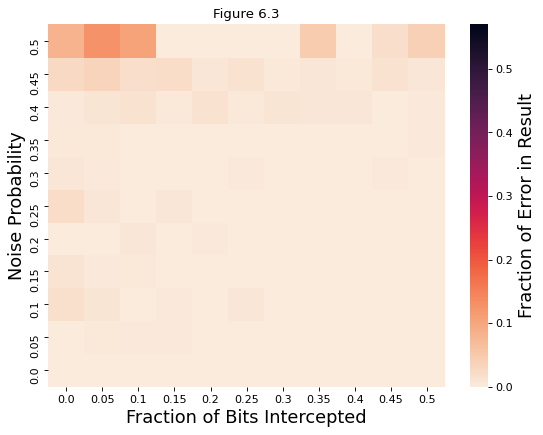

In [13]:
# Data from above is plotted in a heat plot in Figure 6.3
# This data can be compared with that from Figure 5.1 to see the efficacy of Error Elimination and Privacy Amplification
np_rounded=[round(p,2) for p in noise_p_list]
fi_rounded=[round(f,2) for f in f_int_list]
plt.figure(figsize=(8, 6), dpi=80)
data=pd.DataFrame(percent_key_errors_w_correction,index=fi_rounded,columns=np_rounded)
ax=sns.heatmap(data, cmap = sns.cm.rocket_r, cbar_kws={'label': 'Fraction of Error in Result'}, vmin=0, vmax=0.57)
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.invert_yaxis()
ax.title.set_text('Figure 6.3')
plt.ylabel("Noise Probability", size=16)
plt.xlabel("Fraction of Bits Intercepted", size=16)
plt.show()

Comparing Figure 6.3 with Figure 5.1 shows how significantly these two protocols have reduced the error in Alice's and Bob's keys, although a decent proportion of bits have definitely been lost in the process. Setting aside this unavoidable consequence, it is certainly impressive how effective the utilized error elimination and privacy amplification protocols are in dealing with resulting error in Alice's and Bob's keys.

## 7. Message Encryption/Decryption Using BB84

Ultimately, the goal of the BB84 QKD protocol is to distribute a private key to use in a one-time pad encryption scheme. We will now illustrate an example of a BB84-generated private key and how it is used in encryption and decryption of a message. As usual, the players in this example are Alice, the message sender, and Bob, the message receiver.

### Encryption/Decryption Helper Functions

In [53]:
import random
import string

all_letters = string.ascii_letters +  string.punctuation + string.whitespace 

def encrypt_message(string, key):
    """
    Our ascii values are indexed 1-84 and this function simply "adds" two letters together 
    (repeating from 1 when the max value is hit). This code was partially taken from StackExchange 
    but was modified to fit our ascii list.
    """
    retval = ""
    for k, v in zip(string, key):
        c_index = all_letters.index(k)
        key_index = all_letters.index(v)
        cipher_index = c_index + key_index
        try:
            retval += all_letters[cipher_index]
        except IndexError:
            cipher_index -= 90
            retval += all_letters[cipher_index]
    return retval


def decrypt_message(encrypted, key):
    """
    This reverses the action done b the "encrypt_message" function.
    """
    retval = ""
    for k, v in zip(encrypted, key):
        c_index = all_letters.index(k)
        key_index = all_letters.index(v)
        decrypt = c_index - key_index
        try:
            retval += all_letters[decrypt]
        except IndexError:
            decrypt += 90
            retval += all_letters[decrypt]
    
    # rstrip gets rid of the padded whitespaces
    return retval.rstrip()

def generate_key(string, length_multiplier=1):
    """
    This generates a random key for whatever sized length of the string is inputted. 
    The length_multiplier factor makes the key x times larger than the orginal string
    for when extra values are needed to compare during key distribution.  Originally 
    designed to use the randint function, it was updated to use qubits to truly
    randomly choose a key.  This is still all in ascii strings.
    """
    key = ['']*(len(string)*length_multiplier)
    # Create binary value between 0-89(7 bits needed for 0-127)
    for idx in range(0,len(string)):

        key_value = 90
        while key_value > 84:
#             # this is using randint
#             random_binaries = randint(2, size=7)
            # this is using qubits for truly random numbers
            random_binaries = true_random_int()
            
            binary_string = ''.join(map(str, random_binaries))
            key_value = int(binary_string, 2)
            
        try:
            key[idx] = all_letters[key_value]
        except IndexError:
            key_value -= 90
            key[idx] = all_letters[key_value]
    return ''.join(map(str, key))

def pad_message(string):
    """
    This pads a message with extra blank spaces so the length of the message
    itself is hidden.  Further security.  All in string format.
    """
#     Let's just make the maximum 32 characters long for now, pad to 64
    padded_message = string
    if len(string) > 32:
        print('Message too long, please shorten to 32 characters long.')
    else:
        padded_message += " "*(64-len(string))
    return padded_message

def letter_to_binary(letter):
    """
    This function takes a single letter, finds its index number from the ascii list,
    then converts that index number into a 7 bit binary equivalent.  The output is 
    and np array of the binary index value in ints.
    """
    letter_idx = all_letters.index(letter)
    string_bin = f'{letter_idx:07b}'
    binary_array = np.ones(7)
    for idx in range(0,len(binary_array)):
        binary_array[idx] = int(string_bin[idx])
    return binary_array

def string_to_binary_array(string):
    """
    This function takes an entire string and will map all ascii values to their binary
    indicies using the letter_to_binary function.
    """
    # 7 bits for each letter
    full_binary_array = np.empty(0)
    for letter in string:
        full_binary_array = np.append(full_binary_array, letter_to_binary(letter))
    return full_binary_array

def binary_array_to_string(full_binary_array):
    """
    This reverses the process of the string_to_binary_array function.  It takes a binary
    strings and puts them back into their ascii equivalent.
    """
    output_string = ''
    for idx in range(0,int(len(full_binary_array)/7)):
        binary_slice = full_binary_array[7*idx:(1+idx)*7]
        binary_slice = binary_slice.tolist()
        binary_slice = [int(i) for i in binary_slice]

        letter_index = int(''.join(map(str, binary_slice)),2)
        output_string = output_string + all_letters[letter_index]
        
    return output_string

In [54]:
def encode_message(bits, bases):
    """
    This function was taken from the Qiskit website.
    This function encodes bits in either the z or x basis.
    """
    message = []
    n = len(bases)
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

def measure_message(message, bases):
    """
    This function was taken from the Qiskit website.
    This function measures bits in either the z or x basis.
    """
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    n = len(bases)
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def eve_measure_message(message, bases, indices):
    """
    This function was taken from the Qiskit website (as "measure_message").  
    It was then later modified by Thomas Chamberlin to only measure a subset
    of the bits in the x or z basis, based on the inputted indicies.
    """
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    n = len(bases)
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[indices[q]].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[indices[q]].h(0)
            message[indices[q]].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[indices[q]], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def remove_garbage(a_bases, b_bases, bits):
    """
    This function was taken from the Qiskit website.
    This removes bits that were measured in different bases.
    """
    good_bits = []
    n=len(a_bases)
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

def sample_bits(bits, selection):
    """
    This function was taken from the Qiskit website.
    This function samples the bits and pops them out of the list.
    """
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample




As an interesting aside, an often-cited failure of classical computing is the impossibility of creating a truly random number generator under its axioms. The best one can do with classical computing is a pseudo-random number generator, which is actually completely deterministic in the sense that given an input value (called a _seed_), the generator will output the same output sequence of random-like numbers every time. The seed itself may be truly random, but is often not. [4]

On the other hand, quantum computing has no such restrictions. The inherent randomness of quantum mechanics allows for the generation of a true random number generator. Below is a prototype of a true random number generator, which places 7 independent qubits initially in Z-basis states into equal superpositions using Hadamard gates on each of them. Measuring each of the qubits in the Z-basis gives a total of 7 bits, which are put together to determine a truly random binary number 0-127. The true randomness comes from the fact that the result of any of the measurements is not known in any sense before the measurement is actually carried out, and each measurement has a 50% chance of being 0 and 50% chance of being 1. In this report, the function `true_random_int` below is used in the generation of a private key through the function `generate_key` in the Encryption/Decryption Helper Functions section above.

In [638]:
def true_random_int():
    """
    This function makes a truly random number generator for values 0-127.
    It takes 7 independent qubits, places them into independent equal superpositions
    through a Hadamard gate and then measures them.  Those 7 random 0's or 1's then
    become the binary equivalent of a random number between 0-127.
    """
    random_binaries = np.ones(7)
    for idx in range(7):
        # Make Circuit
        qc = QuantumCircuit(1,1)
        qc.h(0)
        qc.measure(0,0)
        
        # Do a one shot measurement and check the state
        qasm_sim = Aer.get_backend('qasm_simulator')
        job = qasm_sim.run(assemble(qc), shots=1)
        counts_back = job.result().data()
        
        # keep track if it's a 1 or a 0
        try: 
            random_binaries[idx] = (counts_back['counts'])['0x1']
        except KeyError:
            random_binaries[idx] = 0

    # Just makes them int's 
    random_int_list = random_binaries.tolist()
    random_int_list = [int(i) for i in random_int_list]
    return np.array(random_int_list)
true_random_int()

array([1, 0, 0, 1, 0, 0, 1])

Classically, a one-time pad encryption scheme involves the generation and use of a private key that is distributed from Alice, the message sender, to Bob, the message receiver, over some channel of communication. Unfortunately, this is very easy to intercept, since the measurement of a classical set of bits does not change the bits' state in any way, so Bob has no way of knowing of the interception.

Quantum key distribution (QKD), as its name suggests, distributes the private key by quantum means instead, and as we saw previously in this report, we are able to detect interception relatively well, although the protocol is surely more sensitive to noise than a classical one. After QKD, though, the encryption and decryption of the message using the private key is still carried out classically. An example of such encryption and decryption is given below, which uses several functions from the Encryption/Decryption Helper Functions section above.

In [56]:
orig_st = 'cat in a hat'
# Padded string 
st = pad_message(orig_st)
print('Original message: ')
print(st+'\n')
key = generate_key(st)
print('Random generated key (using randint): ')
print(key+'\n')
x = encrypt_message(st,key)
print('Encrypted message: ')
print(x+'\n')
y = decrypt_message(x,key)
print('Decrypted message: ')
print(y)

Original message: 
cat in a hat                                                    

Random generated key (using randint): 
J`rzL<_'vZAlCh$bsDVEaMBKd.?.GzaZni l$Scf?.]'m<J=Y&=*pm-%@pFJoJF.

Encrypted message: 
(/(At Thc_fXMbX	mxPy GvE
/(=!g,D-SZ-$jg'Y:jzDiDz(

Decrypted message: 
cat in a hat


Now, Alice may utilize the advantages of QKD, the true random number generator `true_random_int`, and classical encryption/decryption to send a message to Bob. We follow the protocol below to simulate an example process which Alice can use to securely send her message. Alice starts off with a message that she wants to send.

1. Alice pads her message with spaces to get the message to a certain length threshold. This is to include more characters in her randomly-generated private key, adding further security.
2. Alice generates a one-time pad (in ASCII) from her message using the `generate_key` function. The one-time pad is made 2 times larger than the message in order to allow extra room for qubits to compare. The more qubits there are to be compared at the end of QKD, the more sure one can be about whether an interceptor has interfered or not.
3. Alice turns one-time pad ASCII equivalents into qubits. All of the ASCII characters used are mapped on indicies 0-84. Numbers 0-127 can be described with a 7-bit binary number. Thus, any given ASCII character can be represented by 7 independent qubits.
4. Alice sends the quantum one-time pad to Bob, carrying out the BB84 protocol.
5. Alice and Bob compare a sample of randomly chosen bits to detect any possible interception.
6. If the one-time pad was deemed to not have been intercepted, Alice and Bob continue to the next step. If they find that the one-time pad has been intercepted, they must start over from step 2.
7. Believing that no interception has occurred, Alice can now send an encrypted message to Bob using her classical one-time pad, which is now officially the private key (generated in step 2).
8. Bob decrypts Alice's encrypted message using his private key (sent by Alice).

These steps are carried out below, showing QKD in action.

In [57]:
## Step 1: Pad Message

orig_st = 'Hopefully this works'
# Padded string 
st = pad_message(orig_st)
print('Original message: ')
print(st)

Original message: 
Hopefully this works                                            


In [58]:
## Step 2: Generate Key

# Makes key *length_multiplier times longer than original
length_multiplier = 2
key = generate_key(st, length_multiplier)
print('Random key generated:')
print(str(key[0:20]) + '...')

Random key generated:
uat{@NfV=j(+i}L`/df!...


In [59]:
## Step 3: Turn Key Into Qubits

n = len(key*7)
# bits is based off of the one time pad converted into binary:
alice_bits = string_to_binary_array(key)
# bases is random for now TODO: make this true random
alice_bases = randint(2, size=n)


# now make it qiskit bits, this is the one time pad
message = encode_message(alice_bits, alice_bases)
print('Alice bits:')
print(str(alice_bits[0:20]) + ' ...')
print('Alice bases:')
print(str(alice_bases[0:20]) + ' ...')
print('\nTotal qubits sent: ' + str(n))

Alice bits:
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.] ...
Alice bases:
[1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1] ...

Total qubits sent: 448


In [60]:
## Step 4: BB84 Protocol with Interception

"""The first two variables in the block below are 
the numbers you would want to sweep if you wanted 
to see how good your detection is.  You do this by 
choosing how many bits (out of 448) Eve eavesdrops, 
and how many qubits of the pad Alice and Bob compare
at the end (max is 224).
E.g. the more bits that Eve measures (n_eve), the 
higher the probability that Alice and Bob will detect 
an eavesdropper.  Similarly, the more bits Alice and 
Bob compare(n_compare), the higher the probability 
Alice and Bob will detect Eve.

Warning: Running this block twice in a row will mess 
up the results because Eve re-samples a random number 
of qubits. If you need to run this again, you need to 
re-run the block above!"""

# Number of bits eve attempts to measure
n_eve=200
# Number of bits that Alice and Bob Compare
n_compare=4

# Eve interception
eve_bit_selection = randint(n, size=n_eve)
eve_bit_selection = random.sample(range(n), n_eve)
eve_bases = randint(2, size=n_eve)
intercepted_message = eve_measure_message(message, eve_bases, eve_bit_selection)


bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)


In [66]:
## Step 5: Alice and Bob Compare Sample

sample_size = n_compare
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str([int(i) for i in alice_sample]))

  bob_sample = [1, 0, 0, 0]
alice_sample = [1, 0, 0, 0]


In [67]:
## Step 6: Decide Whether to Use One-Time Pad as Private Key

# If they match, make a key with the rest of the pad
if bob_sample == alice_sample:
    print('No interception! Using as one time pad.')
else:
    print('Message intercepted, try again!')

No interception! Using as one time pad.


In [640]:
## Step 7: Alice Encrypts and Sends Message

print('Original message: ')
print(orig_st+'\n')

# Alice encrypts message with private key
x = encrypt_message(orig_st,key)
print('Encrypted message: ')
print(x+'\n')

# Alice sends encrypted message to Bob

Original message: 
Hopefully this works

Encrypted message: 
"oI _(q'ed_<qkFl{up=



In [641]:
## Step 8: Bob Decrypts and Reads Message

# Bob decrypts message with private key
y = decrypt_message(x,key)
print('Decrypted message: ')
print(y)

Decrypted message: 
Hopefully this works


## 8. Discussion

Through this report, we have investigated several strengths and drawbacks of the BB84 QKD protocol, as well as error elimination and privacy elimination protocols. The BB84 QKD protocol has been shown to be effective in detecting an eavesdropper/interceptor, which is a key weakness of classical key distribution schemes. This ability to detect an interceptor is the result of quantum principles: any attempt to measure qubits (sent from one party to another) in a basis in which that qubit is not an eigenstate will result in the qubit irreversibly changing in state. This change in state can cause the qubit receiver to measure the state incorrectly even in the qubit's originally intended basis, which can be detected by both sender and receiver upon comparing samples of their respective bits. When this error is detected in the absence of substantial noise, it becomes clear that an interceptor has been listening in on (some fraction of) the communicated qubits between the two parties.

However, over noisy channels (modeled as bit flips), this detection becomes more nuanced. We have seen that the result of interception and noise can look exactly the same up to some multiplicative factor in their respective probabilities of occurrence. Thus, if noise is present, the interceptor may be able to intercept some bits of the message without being reliably detected. Indeed, we have seen that in low noise channels, it is still relatively easy to detect an interceptor with high confidence, but in high noise channels (>25%), it becomes very difficult to impossible to attribute an increase in error between the two parties' bits to an interception of those bits. Fortunately, such noisy channels are very rarely used, and an interceptor will often be a victim to some of the noise anyway, somewhat defeating the purpose of the interception.

Both noise and interception can be protected against with error elimination and privacy amplification protocols introduced in section 6. These protocols involve the use of the parity operation to eliminate errors and consolidate bits to amplify privacy. Through trials on interception with and without noise, we see that the use of both protocols together is highly effective over relevant ranges of noise levels and fractions of qubits intercepted. However, we also saw a slight drawback in the error elimination protocol when most of the qubits are affected by noise (noise probability>0.5): as a result of the repeated XOR parity operation, the sender's and receiver's bits tend to become exact opposites (100% error). This shows the importance of minimizing noise in quantum systems and information channels. A fix for this error is also proposed, where both parties compare a small number of bits after the error elimination protocol and one party flips all bits if there is a high percentage of error (usually near 100%). Since this only occurs in very noisy channels anyway, this issue with the error elimination scheme is often ignored.

Lastly, we dove into the use of QKD for its ultimate purpose: distribution of a one-time pad intended for use as a private key in the encryption, communication, and decryption of a message. The key thing to grasp here is that the encryption/decryption are still conducted classically after QKD is used to distribute a one-time pad generated by the sender. Examples of this type of encryption/decryption using both classical distribution and QKD are presented and discussed in Section 7, in which we see how parties using classical distribution would typically fail at detecting an interceptor, but parties using QKD can successfully detect interception more often than not (assuming acceptable noise).

Of course, there are several ways in which one could expand upon the investigations presented in this report. This report focused on BB84 QKD protocol, its sensitivity to error, and how this sensitivity could be used to detect interceptors in various settings. One could expand upon this by looking into the intercepted message and how much it actually matches the keys of the two communicating parties in these various settings, as well as how privacy amplification destroys the interceptor's knowledge of the bits. Another facet to explore could be the difference in detected error depending on how much noise affects the qubits before and after the interception takes place (the theory for this has mostly been presented in this paper). Lastly, one could diversify and look into the effectiveness of other QKD protocols [2] at communicating a message, detecting interceptors, and dealing with noise.

Finally, we look into some of the recent advancements in QKD systems, which revolve around new protocols, engineering improvements, and communications techniques, such as ground-to-satellite QKD.

Two new protocols are High Dimensional QKD and RR-DPS-QKD. In High Dimensional QKD, a study suggests that more than 1 bit from each detected photon is possible, demonstrating an average of 6.9 bits/photon on a detector. While more bits/photon are possible, this was the limit when taking into account system security. The encoding for this protocol uses arrival times of time-energy entangled photon pairs. The RR-DPS-QKD or Round-Robin, Differential Phase-Shift Quantum Key Distribution, removes the need to monitor channel disturbances for an eavesdropper.  Instead, information about the eavesdropper is defined at some level upfront, and then the receiver measures the differential phase between any two pulses within a pulse train or pulse group sent by Alice. [6]

Some of the remaining challenges for QKD involve the rate at which the private keys are generated, system cost, distance, and security.  Reducing cost of QKD systems is an area that is constantly improving. It has been determined that QKD systems can coexist in the same fiber with intense data traffic, and that room-temperature single-photon detectors are suitable for QKD - thus removing cooling and dark fiber requirements from QKD. These types of findings lead to reduced deployment cost, complexity, and power consumption. Distance will always be a factor due to loss rates in optical fibers.  Specialized repeaters such as: trusted relays, quantum repeaters, or ground-to-satellite transmission, may be necessary in most mediums to combat these losses. [6]

The remaining challenge to making these systems practical is improving on system security. Two techniques found added resiliency to measurement devices and detector – the most vulnerable parts of a QKD system. The first, MDI-QKD, or Measurement device independent QKD, has shown to be highly secure – so much so, that Eve could even manufacture the “black box” measurement apparatus used on MDI-QKD. Because of its security and ability to mitigate side-channel attacks, the MDI-QKD approach can be placed in untrusted relays and shared among many QKD users. It’s transmission rate of 1 GHz corresponds to a secret key rate of 10 Mbit/s, which is sufficient for many applications. It is important to note that this QKD approach assumes that Eve is unable to interfere with Alice and Bob’s state preparation process.

Another approach to system security is DDI-QKD , or Detector device independent QKD, which combines the strong security of MDI-QKD with conventional QKD efficiencies. In this protocol, the receiver uses a trusted optics network to decode information on photons received through Bell state measurements. Unfortunately, this protocol has not completely proven its ability to remove detector side-channel attacks.

A large threat to QKD systems are Trojan Horse attacks. In an optical system, Eve sends “Trojan photons” to Alice’s secure module. After reaching Alice’s module, the trojan photons are encoded with the same information Alice sends to Bob, while some of Eve’s original photons are reflected back to Eve, delivering information to her. Luckily, these THAs can be mitigated by using extra components – such as a an active, phase randomizer and watchdog detector. These can be added at the expense of become a costlier, more complex system. [7]

Larger QKD networks will be necessary to bring QKD into practical use. A star topological network (one with at most one intermediate node between any two users has already been demonstrated using MDI-QKD. The vision for these networks is that they will be cheap, since simple transmitters can be used by each user. The key to the network’s operation will rely on outsourcing the complicated devices to a network operator (who can even be untrusted due to the security of MDI-QKD). While QKD networks are promising, they are still limited in the distance they can cover. Advancements in trusted relays, quantum repeaters, and ground-to-satellite transmissions, will make QKD networks more of a reality.

## Citations

[1] The Jupyter Book Community. (n.d.). Quantum Key Distribution. Qiskit. https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html. 

[2] Haitjema, M. (n.d.). A Survey of the Prominent Quantum Key Distribution Protocols. Quantum Key Distribution - QKD. https://www.cse.wustl.edu/~jain/cse571-07/ftp/quantum/#bb84. 

[3] Blumenthal, M. (n.d.). Encryption: Strengths and Weaknesses of Public-key Cryptography . http://www.csc.villanova.edu/~mdamian/Past/csc3990fa08/csrs2007/01-pp1-7-MattBlumenthal.pdf. 

[4] Kroese, D. P. (2011). Monte Carlo Methods. https://people.smp.uq.edu.au/DirkKroese/mccourse.pdf. 

[5] Clader, B. D. (n.d.). Quantum Cryptography. 04A_Slides.pdf. https://blackboard.jhu.edu/bbcswebdav/pid-9269103-dt-content-rid-98712252_2/courses/EN.615.781.81.SP21/Module04/04A_Slides.pdf. 

[6] Tian Zhong et al 2015 New J. Phys. 17 022002

[7] Lucamarini, M. et al. Practical security bounds against the Trojan-horse attack in quantum key distribution. Phys. Rev. X 5, 031030. https://doi.org/10.1103/PhysRevX.5.031030 (2015).